In [56]:
#import dependencies
import pandas as pd
import numpy as np
import os
from datetime import datetime
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
from bokeh.models import LinearAxis, Range1d

import seaborn as sns

In [11]:
prices_df = pd.read_csv(f'../data/clean_data/hist_daily_stock_fut_price.csv', index_col = 0, parse_dates = True, infer_datetime_format = True)

prices_df = prices_df[['corn', 'cornf']]

returns_df = prices_df.pct_change().dropna()

returns_df.head(1)

,corn,cornf
2011-09-20,-0.00241,-0.002889


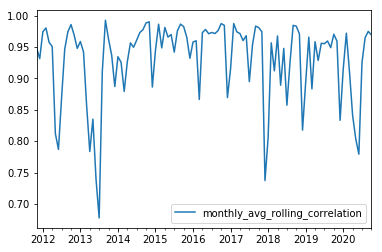

In [60]:
rolling_returns_df = returns_df.rolling(window = 30).mean().dropna()
rolling_returns_df = rolling_returns_df.resample('MS').mean()

rolling_vol_df = returns_df.rolling(window = 30).std().dropna()

rolling_corr_df = returns_df['corn'].rolling(window = 30).corr(returns_df['cornf']).dropna()
rolling_corr_df = pd.DataFrame(rolling_corr_df.resample('MS').mean(), columns = ['monthly_avg_rolling_correlation'])

rolling_corr_plot = rolling_corr_df.plot()

plt.savefig(f'../images/jg_fig_temp.png')

In [13]:
usda_df = pd.read_csv(f'../data/clean_data/usda_data/usda_data_corn_grain.csv', index_col = False)

usda_df.head(1)

,commodity,sub_commodity,location,stat,unit,frequency,year,period,value
0,CORN,GRAIN,AL,PRODUCTION,$,ANNUAL,2000,YEAR,23166000.0


In [14]:
corn_df = usda_df.loc[(usda_df['location'] == 'US') & (usda_df['unit'] == 'BU'), :]

corn_df['period_split'] = corn_df['period'].apply(lambda x: x.split())
corn_df['data_type'] = corn_df.apply(lambda x: 'forecast' if x['period_split'][-1] == 'FORECAST' else 'actual', axis = 1)
corn_df['month'] = corn_df.apply(lambda x: 'dec' if x['period'] == 'YEAR' else (x['period_split'][-1].lower() if len(x['period_split']) == 3 else x['period_split'][-2].lower()), axis = 1)
corn_df['date'] = corn_df.apply(lambda x: datetime(int(x['year']), datetime.strptime(x['month'], '%b').month, 1), axis = 1)
corn_df['date'] = pd.to_datetime(corn_df['date'], format = '%Y%m%d')
corn_df = corn_df.sort_values(by = 'date')

corn_df = corn_df[['commodity', 'stat', 'year', 'data_type', 'month', 'date', 'value']].reset_index(drop = True)

corn_df.head()

,commodity,stat,year,data_type,month,date,value
0,CORN,STOCKS,2000,actual,mar,2000-03-01,5.601895e+09
1,CORN,STOCKS,2000,actual,jun,2000-06-01,3.585938e+09
2,CORN,STOCKS,2000,actual,sep,2000-09-01,1.717549e+09
3,CORN,PRODUCTION,2000,actual,dec,2000-12-01,9.915051e+09
4,CORN,STOCKS,2000,actual,dec,2000-12-01,8.529634e+09


In [15]:
corn_prod_df = corn_df.loc[corn_df['stat'] == 'PRODUCTION', :]
corn_prod_df['change_(%)'] = corn_prod_df['value'].pct_change()
corn_prod_df = corn_prod_df.set_index('date')


corn_stock_df = corn_df.loc[corn_df['stat'] == 'STOCKS', :]
corn_stock_df['change_ (%)']  = corn_stock_df['value'].pct_change()
corn_stock_df = corn_stock_df.set_index('date')

In [49]:
prod_data_df = rolling_corr_df.merge(corn_prod_df, how = 'left', left_index = True, right_index = True)
prod_data_df = prod_data_df.fillna(method = 'ffill').dropna()
prod_data_df = prod_data_df.reset_index(drop = True)
prod_data_df['report_date'] = prod_data_df.apply(lambda x: datetime(int(x['year']), datetime.strptime(x['month'], '%b').month, 1), axis = 1)

prod_data_df = prod_data_df.groupby('report_date')['data_type', 'monthly_avg_rolling_correlation', 'change_(%)'].mean()

prod_data_df.head()

,monthly_avg_rolling_correlation,change_(%)
report_date,,
2011-12-01,0.907811,-0.008963
2012-08-01,0.946651,-0.124685
2012-09-01,0.974068,-0.004752
2012-10-01,0.985705,-0.002017
2012-11-01,0.969175,0.001818


In [57]:
def twinx(plot, element):
    # Setting the second y axis range name and range
    start, end = (element.range(1))
    label = element.dimensions()[1].pprint_label
    plot.state.extra_y_ranges = {"foo": Range1d(start=start, end=end)}
    # Adding the second axis to the plot. 
    linaxis = LinearAxis(axis_label=label, y_range_name='foo')
    plot.state.add_layout(linaxis, 'right')

In [59]:
prod_data_plot_a = prod_data_df['monthly_avg_rolling_correlation'].hvplot(yaxis = 'right')
prod_data_plot_b = prod_data_df['change_(%)'].hvplot(yaxis = 'left').opts(hooks = [apply_formatter])

# prod_data_plot_a
# prod_data_plot_b
prod_data_plot_a * prod_data_plot_b


 name 'GlyphRenderer' is not defined


:Overlay
   .Curve.Monthly_avg_rolling_correlation                   :Curve   [report_date]   (monthly_avg_rolling_correlation)
   .Curve.Change_left_parenthesis_percent_right_parenthesis :Curve   [report_date]   (change_(%))

In [9]:
stock_data_df = rolling_corr_df.merge(corn_stock_df, how = 'left', left_index = True, right_index = True)
stock_data_df = stock_data_df.fillna(method = 'ffill').dropna()

stock_data_df.head()

,monthly_avg_rolling_correlation,commodity,stat,year,data_type,month,value,change_ (%)
2011-12-01,0.931379,CORN,STOCKS,2011.0,actual,dec,9.646823e+09,7.554840
2012-01-01,0.974189,CORN,STOCKS,2011.0,actual,dec,9.646823e+09,7.554840
2012-02-01,0.980317,CORN,STOCKS,2011.0,actual,dec,9.646823e+09,7.554840
2012-03-01,0.957353,CORN,STOCKS,2012.0,actual,mar,6.023356e+09,-0.375612
2012-04-01,0.950682,CORN,STOCKS,2012.0,actual,mar,6.023356e+09,-0.375612
